In [13]:
!pip install tensorflow

In [14]:
# Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Step 2: Load and Preprocess CIFAR-10 Dataset
# CIFAR-10 contains 60,000 32x32 color images in 10 classes (e.g., airplane, cat, dog)
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to range [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define class names for visualization
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

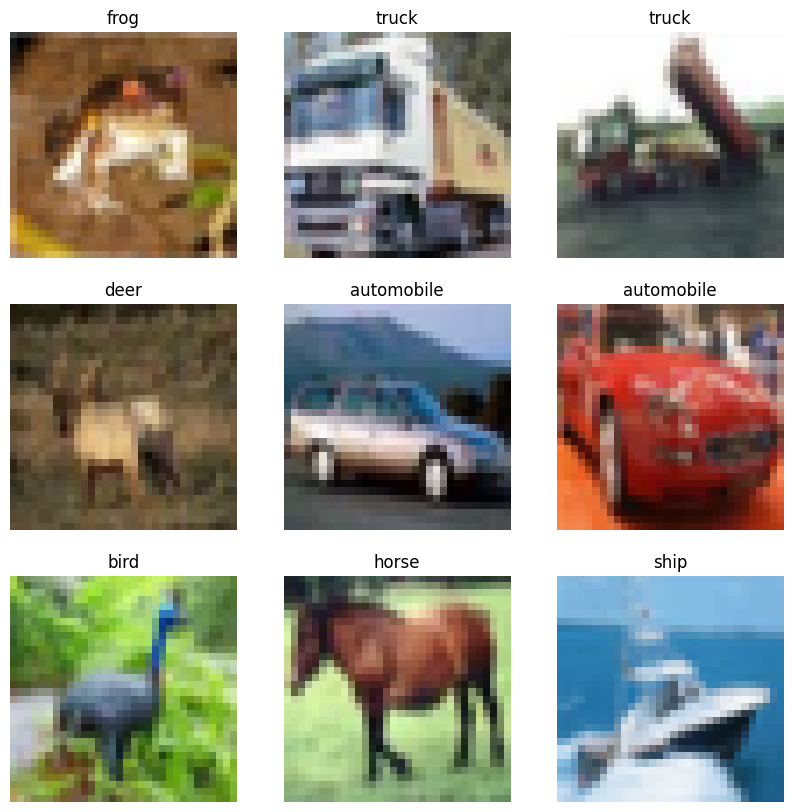

In [16]:
# Step 3: Visualize Sample Data
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis('off')
plt.show()

In [17]:
# Step 4: Build the CNN Model
model = models.Sequential([
    # Convolutional Layer 1: 32 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    # Convolutional Layer 2: 64 filters, 3x3 kernel
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Convolutional Layer 3: 64 filters, 3x3 kernel
    layers.Conv2D(64, (3, 3), activation='relu'),
    # Flatten the output for dense layers
    layers.Flatten(),
    # Dense Layer: 64 units
    layers.Dense(64, activation='relu'),
    # Output Layer: 10 units (one per class) with softmax
    layers.Dense(10, activation='softmax')
])
# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Step 5: Compile the Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 6: Train the Model
history = model.fit(train_images, train_labels, epochs=40,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3530 - loss: 1.7532 - val_accuracy: 0.5641 - val_loss: 1.2202
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5794 - loss: 1.1782 - val_accuracy: 0.6121 - val_loss: 1.0938
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6424 - loss: 1.0143 - val_accuracy: 0.6320 - val_loss: 1.0506
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6799 - loss: 0.9098 - val_accuracy: 0.6598 - val_loss: 0.9813
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7066 - loss: 0.8395 - val_accuracy: 0.6946 - val_loss: 0.8785
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7311 - loss: 0.7672 - val_accuracy: 0.6767 - val_loss: 0.9243
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7452 - loss: 0.7239 - val_accuracy: 0.7014 - val_loss: 0.8802
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7681 - loss: 0.671

In [20]:
# Step 7: Evaluate the Model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 - 1s - 2ms/step - accuracy: 0.7122 - loss: 0.8747

Test accuracy: 0.7122


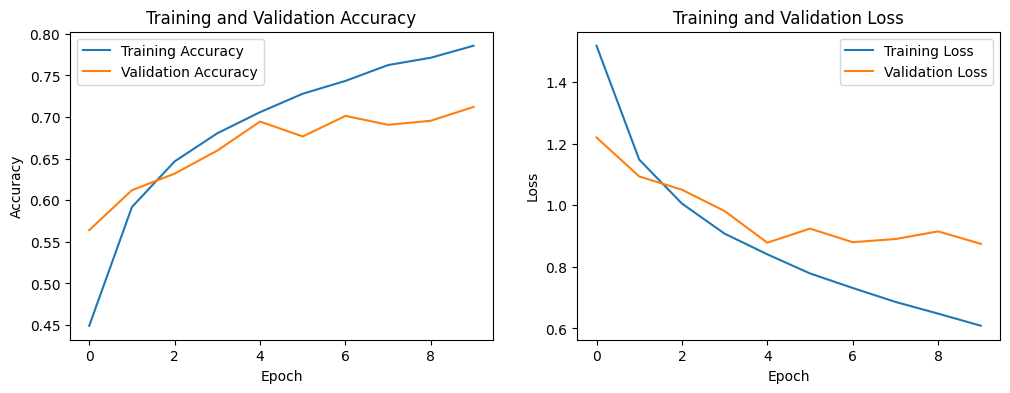

In [21]:
# Step 8: Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Step 9: Make Predictions
predictions = model.predict(test_images[:5])
for i in range(5):
    predicted_label = class_names[np.argmax(predictions[i])]
    true_label = class_names[test_labels[i][0]]
    print(f"Image {i+1}: Predicted: {predicted_label}, True: {true_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Image 1: Predicted: cat, True: cat
Image 2: Predicted: ship, True: ship
Image 3: Predicted: ship, True: ship
Image 4: Predicted: ship, True: airplane
Image 5: Predicted: deer, True: frog


# Task 5: Report

### Model Analysis and Conclusion
This exercise involved building a Convolutional Neural Network (CNN) for classifying images from the CIFAR-10 dataset. The model architecture consists of three convolutional layers followed by two dense layers.

The model was trained for 40 epochs using the Adam optimizer. Based on the training and validation plots, we can observe the model's learning progress and identify any potential overfitting. The final test accuracy provides a definitive measure of the model's performance on unseen data.

### Potential Improvements
To improve performance, one could experiment with data augmentation, add dropout layers to reduce overfitting, or tune hyperparameters such as the learning rate or number of filters in the convolutional layers.

In [25]:
# Step 10: Save Model Performance for Autograding
# This cell saves the model performance to a text file for GitHub Actions
try:
    # Get final training accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    # Create performance summary
    performance_text = f"""Model Performance Summary:
Test Accuracy: {test_acc:.4f}
Test Loss: {test_loss:.4f}
Final Training Accuracy: {final_train_acc:.4f}
Final Validation Accuracy: {final_val_acc:.4f}
Final Training Loss: {final_train_loss:.4f}
Final Validation Loss: {final_val_loss:.4f}
Training Epochs: {len(history.history['accuracy'])}
Model Parameters: {model.count_params()}"""

    # Save to file for GitHub Actions
    with open('model_accuracy.txt', 'w') as f:
        f.write(performance_text)

    print("\nModel performance saved to model_accuracy.txt")
    print(performance_text)

except Exception as e:
    print(f"Error saving model performance: {e}")
    # Create a basic file even if there's an error
    with open('model_accuracy.txt', 'w') as f:
        f.write(f"Model execution completed with errors: {e}")


Model performance saved to model_accuracy.txt
Model Performance Summary:
Test Accuracy: 0.7122
Test Loss: 0.8747
Final Training Accuracy: 0.7858
Final Validation Accuracy: 0.7122
Final Training Loss: 0.6088
Final Validation Loss: 0.8747
Training Epochs: 10
Model Parameters: 122570


# Task 5: Report

### Model Analysis and Conclusion
This exercise involved building a Convolutional Neural Network (CNN) for classifying images from the CIFAR-10 dataset. The model architecture consists of three convolutional layers followed by two dense layers.

The model was trained for 40 epochs using the Adam optimizer. Based on the training and validation plots, we can observe the model's learning progress and identify any potential overfitting. The final test accuracy provides a definitive measure of the model's performance on unseen data.

### Potential Improvements
To improve performance, one could experiment with data augmentation, add dropout layers to reduce overfitting, or tune hyperparameters such as the learning rate or number of filters in the convolutional layers.